## Introduction

This notebook illustrates how we can compare descriptions using cosine similarity. It does so in two ways. 

The first example builds simple binary vectors for every document, with 1 if a word is present and 0 otherwise. We then calcuate cosine similarty using these vectors. We don't do this for all parts of speech, at the moment the code looks for nouns, verbs and adjectives.

The second example calculates cosine similarity using Spacy's inbuilt function, which uses Word2Vec to compare similarity. This means that words with similar **context** (trained empirically) are more similar.

**The program reads in the descriptions collected based on pictures you described in the lecture.**

**The first block of our code initialises libraries and reads in data. We only need to do this once.**

In [11]:
import OSGridConverter #To convert from =SGB36 to WGS84
import pandas as pd #To use pandas for elegant data handling
import spacy #Our NLP tools
import matplotlib.pyplot as plt #To plot results
from matplotlib.figure import Figure #To plot results
from matplotlib.ticker import MaxNLocator #To plot results
import numpy as np #To do some numerical things
import scipy
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import DistanceMetric
from math import radians
import math # To calculate square root

#import os #We import os to stop a weird kernel crash...
#os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

#Load a language model to do NLP
nlp = spacy.load("en_core_web_md") # We can't use the sm model here because it doesn't calculate token2vec

In [18]:
#Read in the data
data = pd.read_csv('./data/landscapes_total_by_name.csv')
print(len(data))
data = data.sort_values('picture') ## Sort by pictures

data

162


,name,picture,text
0,anjing,B1,there are some snow mountain after green mount...
114,roph,B1,My view this afternoon after the beautiful hik...
108,roba,B1,Wandering in the Alps. We're going to the glacier
66,mast2,B1,Once again a beautiful day in the Swiss alps w...
120,sema,B1,Look at those big mountains and green meadows....
...,...,...,...
95,nibe,B6,Fantastic view over the Vierwaldstättersee! On...
47,geha,B6,Vierwaldst„ttersee. Switzerland. Lake. Nature....
41,fati,B6,Such an unreal view of the Vierwaldstättersee!...
131,sesc,B6,Can anyone guess where this is? It almost look...


Build a dictionary of terms in all our documents which we then use for building vectors for similarity comparisons.

In [19]:
docs = list(nlp.pipe(data.text, batch_size=100))

#Create a list of all tokens we want to keep in our collection
pos = set()
for doc in docs:
    for token in doc:
        if token.pos_ == 'NOUN': #Here we choose which parts of speech we keep
            pos.add(token.lemma_)
pos = (sorted(list(pos)))
print(pos)

['#', '%', 'People', 'adventure', 'afternoon', 'air', 'alp', 'alpine', 'alps', 'am', 'angle', 'antmosphere', 'apartment', 'area', 'arrival', 'atmosphere', 'autumn', 'back', 'background', 'bar', 'beauty', 'bed', 'beer', 'bench', 'bevor', 'bikeride', 'bird', 'bit', 'blue', 'boat', 'body', 'book', 'bottom', 'break', 'breakfast', 'buiding', 'building', 'buliding', 'cablecar', 'camera', 'case', 'cat', 'center', 'chance', 'city', 'climate', 'climb', 'cloud', 'coffee', 'color', 'colour', 'combination', 'comination', 'company', 'complex', 'concert', 'connection', 'conqueror', 'construction', 'contrast', 'core', 'corner', 'country', 'countryside', 'cover', 'cow', 'cowbell', 'crane', 'cream', 'creek', 'crossroad', 'crystal', 'day', 'difference', 'distance', 'district', 'dog', 'down', 'dream', 'drone', 'ear', 'effort', 'element', 'emerald', 'equipment', 'evaluation', 'evening', 'experience', 'eye', 'faire', 'fairy', 'fairytale', 'fantasy', 'farmland', 'favourite', 'feeling', 'field', 'fire', 'fla

In [20]:
#Create an empty data frame to store the term vectors we are going to build
vectors = pd.DataFrame(0, data.text, pos)

#Build the binary vectors, iterating through each document
i=0
for doc in docs:
    doc = list(map(str, doc))
    for n in pos:
        a = vectors.columns.get_loc(n)
        if n in [x.lower() for x in list(doc)]:
            vectors.iloc[i, a] = 1
    i=i+1

#print(vectors) #This is a term document indcidence matrix as we say earlier in the course

Compare pairwise all documents using their binary term incidence matrices. Similar documents have cosine ~1, documents with no overlap have cosine = 0.

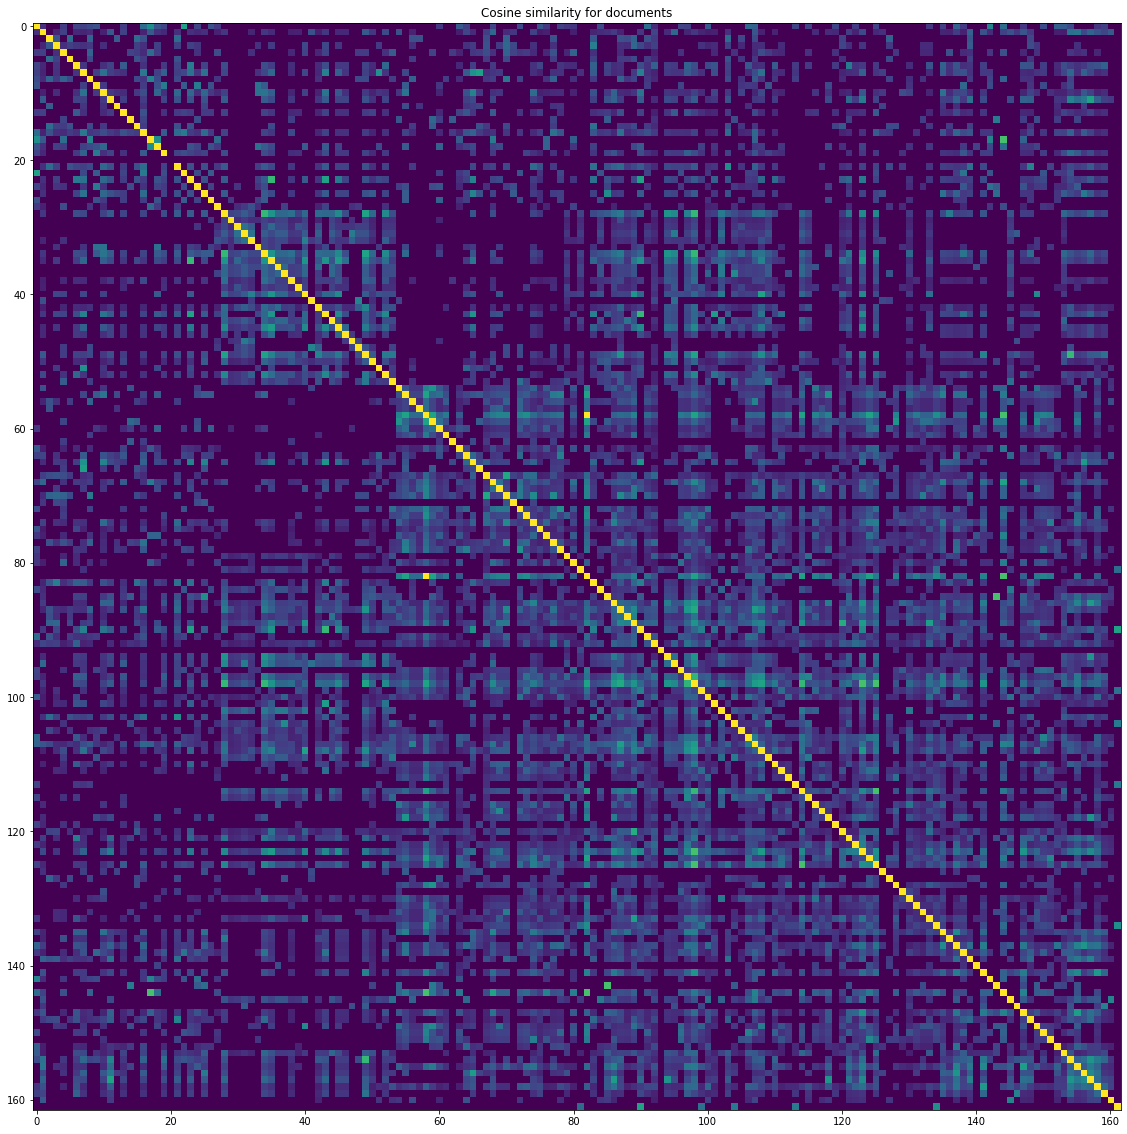

In [21]:
cosine = cosine_similarity(vectors) # We can calculate cosine using these binary vectors

#print(cosine)

fig2 = plt.figure(figsize = (20,20)) # create a 5 x 5 figure 
ax = fig2.add_subplot(111)
ax.imshow(cosine, interpolation='none')
ax.set_title('Cosine similarity for documents')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.show() #Plot the cosine similarity. Remember, the diagonal is 1 and the matrix is symmetric

In [16]:
#Look at content of potentially interesting documents
a = data.columns.get_loc('text')

print(data.iloc[1, a])
print()
print(data.iloc[22, a])
print()
print(data.iloc[18, a])



The approximate geographic core of Switzerland. A view of a multifacetted landscape. From the Vierwaldstättersee  on to ist surroundings further to the prealpine mountains around it to the snowy peaks of the alps in the back  this sight is so majestic that many a person has travelled from quite far a way to get a grasp of this beauty.

Drinking a beer in a rooftop bar  having a view over Basel. The Roche Tower is prominent in the skyline. The trams are loud.

Walking by the lake. Beautiful yellow and violet flowers near the shore. At the next bench  I will sit down and read a book while enjoying the view and the weather. 


Compare documents using word2vec. We can filter the documents so only some terms are used. Important to remember that this is still a bag of words approach.

<ipython-input-17-6f4d91048a3c>:11: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  value = d1.similarity(d2)


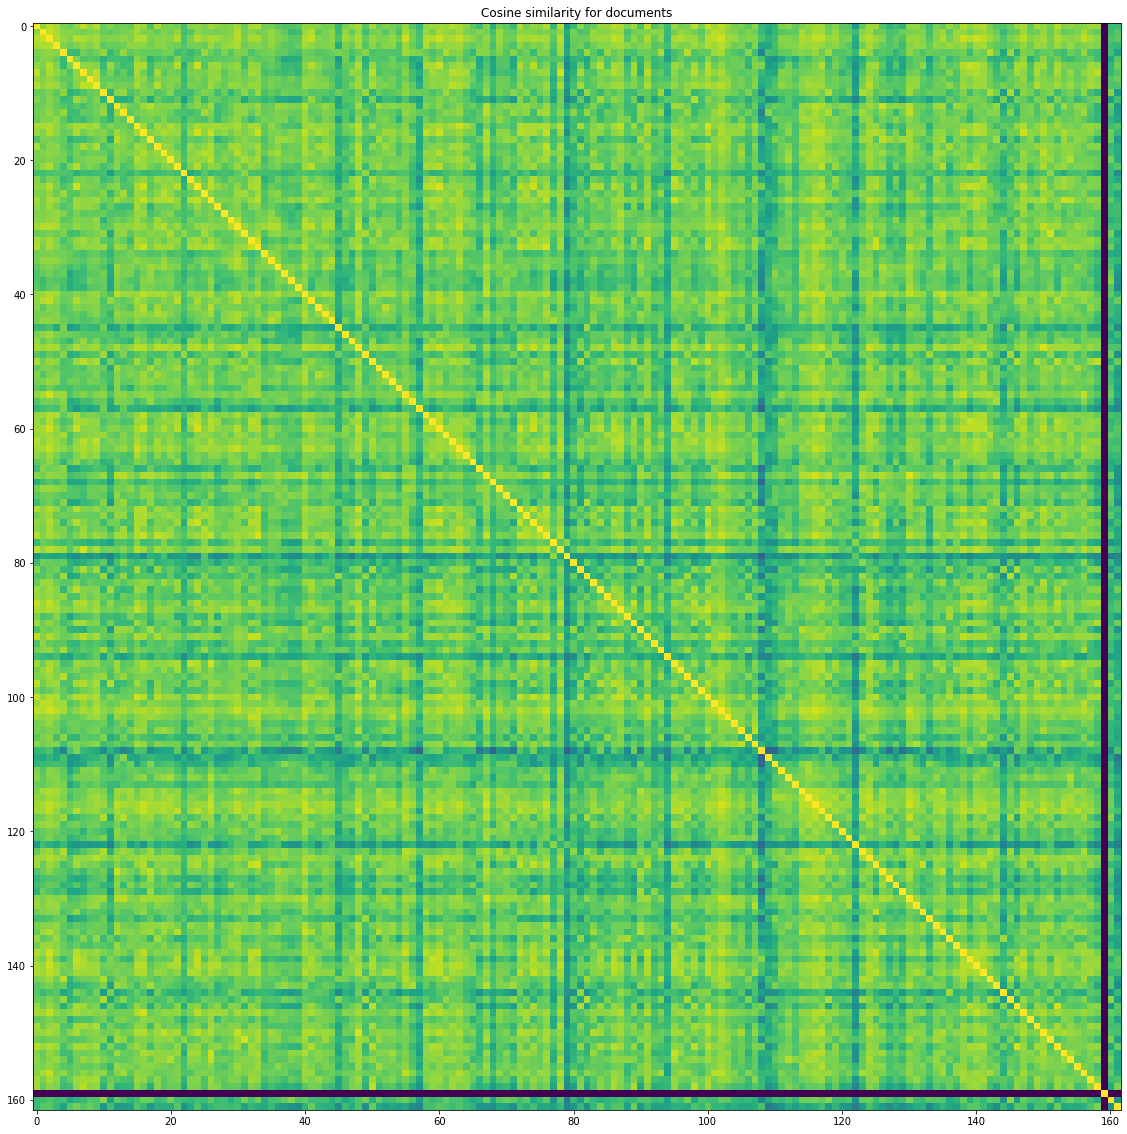

In [17]:
#Calculate similarity between documents using cosine similarity in Spacy (based on Word2Vec)
cosine = [] 
#In this code we don't use all the words; we filter out entities, stop words and punctuation
for doc1 in docs:
    s1 = " ".join([ent.lemma_ for ent in doc1 if ent.pos_ == 'NOUN' or ent.pos_ == 'ADJ']) 
    d1 = nlp(s1)    
    sim = []
    for doc2 in docs:
        s2 = " ".join([ent.lemma_ for ent in doc2 if ent.pos_ == 'NOUN' or ent.pos_ == 'ADJ'])
        d2 = nlp(s2)
        value = d1.similarity(d2)
        #value = doc1.similarity(doc2)
        sim.append(value)
    cosine.append(sim)
    
#Plot the similarity matrix again
fig2 = plt.figure(figsize = (20,20)) 
ax = fig2.add_subplot(111)
ax.imshow(cosine, interpolation='none')
ax.set_title('Cosine similarity for documents')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

In [9]:
#Look at content of potentially interesting documents
a = data.columns.get_loc('text')

print(data.iloc[11, a])
print()
print(data.iloc[15, a])

print(data.iloc[3])

Beautiful view over the mountains of Switzerland. Calm and peaceful antmosphere to free your mind.  

I really like the alps during autumn  when the grass and the trees have this redish look.
name                                                   mast2
picture                                                   B1
text       Once again a beautiful day in the Swiss alps w...
Name: 66, dtype: object


In [10]:
#output all dependencies so that we can reproduce the notebook (we only need this to set things up for Binder)
#%load_ext watermark
#%watermark --iversions